# Importing & Understanding

In [56]:
import pandas as pd

# Disable warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Load the Excel file to inspect the sheets and content
file_path = '/content/E-commerce_data.xlsx'

# Load all sheets from the Excel file
excel_data = pd.ExcelFile(file_path)

# List all sheet names
sheet_names = excel_data.sheet_names

# Load each sheet into a dictionary for further inspection
sheets_data = {sheet: excel_data.parse(sheet) for sheet in sheet_names}

# Display the sheet names and the first few rows of each sheet
sheet_names, {sheet: data.head() for sheet, data in sheets_data.items()}


(['customers', 'genders', 'cities', 'transactions', 'branches', 'merchants'],
 {'customers':    customer_id  join_date  city_id  gender_id
  0            1 2022-01-08        7          1
  1            2 2023-05-02       20          2
  2            3 2023-05-14       15          1
  3            4 2022-11-25       11          2
  4            5 2023-04-26        8          1,
  'genders':    gender_id gender_name
  0          1        Male
  1          2      Female,
  'cities':    city_id         city_name
  0        1             Cairo
  1        2        Alexandria
  2        3              Giza
  3        4  Shubra El-Kheima
  4        5         Port Said,
  'transactions':    transaction_id  customer_id transaction_date transaction_status  \
  0               1          733       2024-05-11         subscribed   
  1               2          631       2023-05-15             burned   
  2               3          309       2022-11-13         subscribed   
  3               4       

**The Excel file contains the following six sheets, corresponding to the dataset you described:**

**1. customers:**

Contains customer details with columns: customer_id, join_date, city_id, and gender_id.

**2. genders:**

Contains gender information with columns: gender_id, gender_name.

**3. cities:**

Contains city details with columns: city_id, city_name.

**4. transactions:**

Contains transaction details with columns: transaction_id, customer_id, transaction_date, transaction_status, coupon_name, burn_date, branch_id.

**5. branches:**

Contains branch details with columns: branch_id, merchant_id.

**6. merchants:**

Contains merchant information with columns: merchant_id, merchant_name.


# Cleaning & Pre-Processing

In [57]:
# Assuming sheets_data is a dictionary containing the dataframes for each sheet

for sheet_name, data in sheets_data.items():
  # Remove duplicate rows
  sheets_data[sheet_name] = data.drop_duplicates()

  # Handle missing values (replace with appropriate strategy)
  # Example: Fill missing values with the mean for numerical columns
  for column in data.columns:
    if pd.api.types.is_numeric_dtype(data[column]):
      sheets_data[sheet_name][column].fillna(data[column].mean(), inplace=True)
    # Example: Fill missing values with 'Unknown' for categorical columns
    else:
      sheets_data[sheet_name][column].fillna('Unknown', inplace=True)


In [58]:
# Inspect for missing values in each sheet
for sheet_name, data in sheets_data.items():
  print(f"Missing values in '{sheet_name}':\n{data.isnull().sum()}\n")


# Check for duplicate rows in each sheet
for sheet_name, data in sheets_data.items():
  print(f"Duplicate rows in '{sheet_name}': {data.duplicated().sum()}")


Missing values in 'customers':
customer_id    0
join_date      0
city_id        0
gender_id      0
dtype: int64

Missing values in 'genders':
gender_id      0
gender_name    0
dtype: int64

Missing values in 'cities':
city_id      0
city_name    0
dtype: int64

Missing values in 'transactions':
transaction_id        0
customer_id           0
transaction_date      0
transaction_status    0
coupon_name           0
burn_date             0
branch_id             0
dtype: int64

Missing values in 'branches':
branch_id      0
merchant_id    0
dtype: int64

Missing values in 'merchants':
merchant_id      0
merchant_name    0
dtype: int64

Duplicate rows in 'customers': 0
Duplicate rows in 'genders': 0
Duplicate rows in 'cities': 0
Duplicate rows in 'transactions': 0
Duplicate rows in 'branches': 0
Duplicate rows in 'merchants': 0


In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Data preparation
# Convert relevant date columns to datetime
sheets_data['customers']['join_date'] = pd.to_datetime(sheets_data['customers']['join_date'], errors='coerce')
sheets_data['transactions']['transaction_date'] = pd.to_datetime(sheets_data['transactions']['transaction_date'], errors='coerce')
sheets_data['transactions']['burn_date'] = pd.to_datetime(sheets_data['transactions']['burn_date'], errors='coerce')

# Merge customers with gender and city data for demographic insights
customers = sheets_data['customers'].merge(sheets_data['genders'], on='gender_id', how='left')\
                                    .merge(sheets_data['cities'], on='city_id', how='left')

In [60]:
# Preparing data for coupon usage over time
# Group by transaction date and transaction status
coupon_usage = sheets_data['transactions'].groupby([sheets_data['transactions']['transaction_date'].dt.to_period('M'), 'transaction_status']).size().unstack().fillna(0)

In [61]:
# Merge transactions with cities and branches for city-wise and branch-wise analysis
transactions_with_branches = sheets_data['transactions'].merge(sheets_data['branches'], on='branch_id', how='left')
transactions_with_cities = transactions_with_branches.merge(sheets_data['customers'], on='customer_id', how='left').merge(sheets_data['cities'], on='city_id', how='left')

# Filter only burnt coupons
burnt_coupons = transactions_with_cities[transactions_with_cities['transaction_status'] == 'burned']

# Save The Cleaned Data For Power BI

In [62]:
# Save the cleaned dataframes to a new Excel file
with pd.ExcelWriter('cleaned_ecommerce_data.xlsx') as writer:
  for sheet_name, data in sheets_data.items():
    data.to_excel(writer, sheet_name=sheet_name, index=False)

  customers.to_excel(writer, sheet_name='customers_merged', index=False)
  coupon_usage.to_excel(writer, sheet_name='coupon_usage', index=True)
  transactions_with_cities.to_excel(writer, sheet_name='transactions_with_cities', index=False)
  burnt_coupons.to_excel(writer, sheet_name='burnt_coupons', index=False)

print("Cleaned data saved to 'cleaned_ecommerce_data.xlsx'")


Cleaned data saved to 'cleaned_ecommerce_data.xlsx'


# Visualization

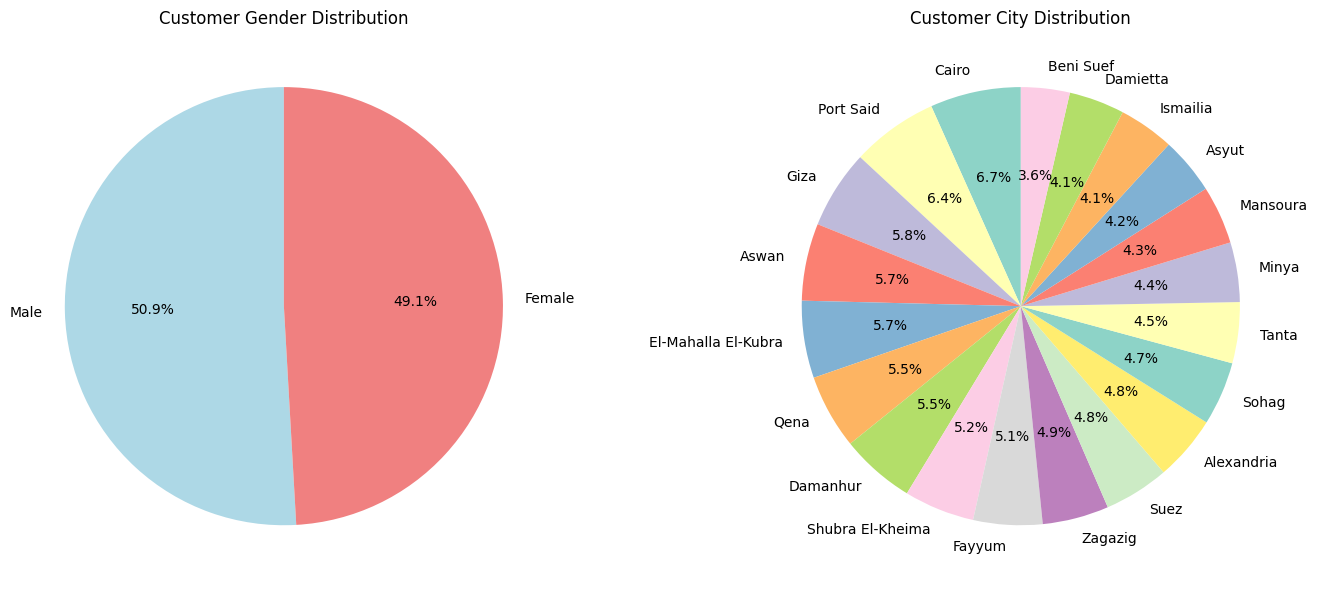

In [63]:
# Visual 1: Pie chart for customer gender distribution
gender_dist = customers['gender_name'].value_counts()

# Visual 2: Pie chart for customer city distribution
city_dist = customers['city_name'].value_counts()

# Plot customer demographics
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Gender distribution pie chart
axes[0].pie(gender_dist, labels=gender_dist.index, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightcoral'])
axes[0].set_title('Customer Gender Distribution')

# City distribution pie chart
axes[1].pie(city_dist, labels=city_dist.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set3", len(city_dist)))
axes[1].set_title('Customer City Distribution')

plt.tight_layout()
plt.show()

**Here are the pie charts showing customer demographics:**

**Customer Gender Distribution:** Displays the percentage breakdown of customers by gender.

**Customer City Distribution:** Shows the proportion of customers from different cities.

<Figure size 1000x800 with 0 Axes>

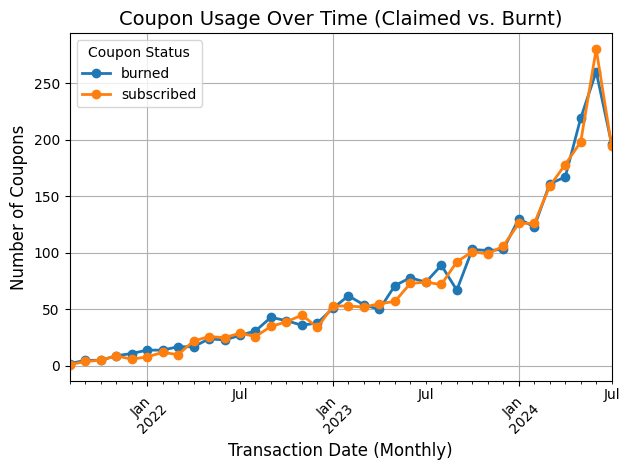

In [64]:
# Visual 3: Time-series line chart for coupon usage
plt.figure(figsize=(10, 8))
coupon_usage.plot(kind='line', marker='o', linewidth=2)

plt.title('Coupon Usage Over Time (Claimed vs. Burnt)', fontsize=14)
plt.xlabel('Transaction Date (Monthly)', fontsize=12)
plt.ylabel('Number of Coupons', fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)
plt.legend(title='Coupon Status', loc='upper left')
plt.tight_layout()
plt.show()

The time-series line chart illustrates Coupon Usage Over Time, showing the number of claimed versus burnt coupons on a monthly basis. This helps in understanding usage trends over time.

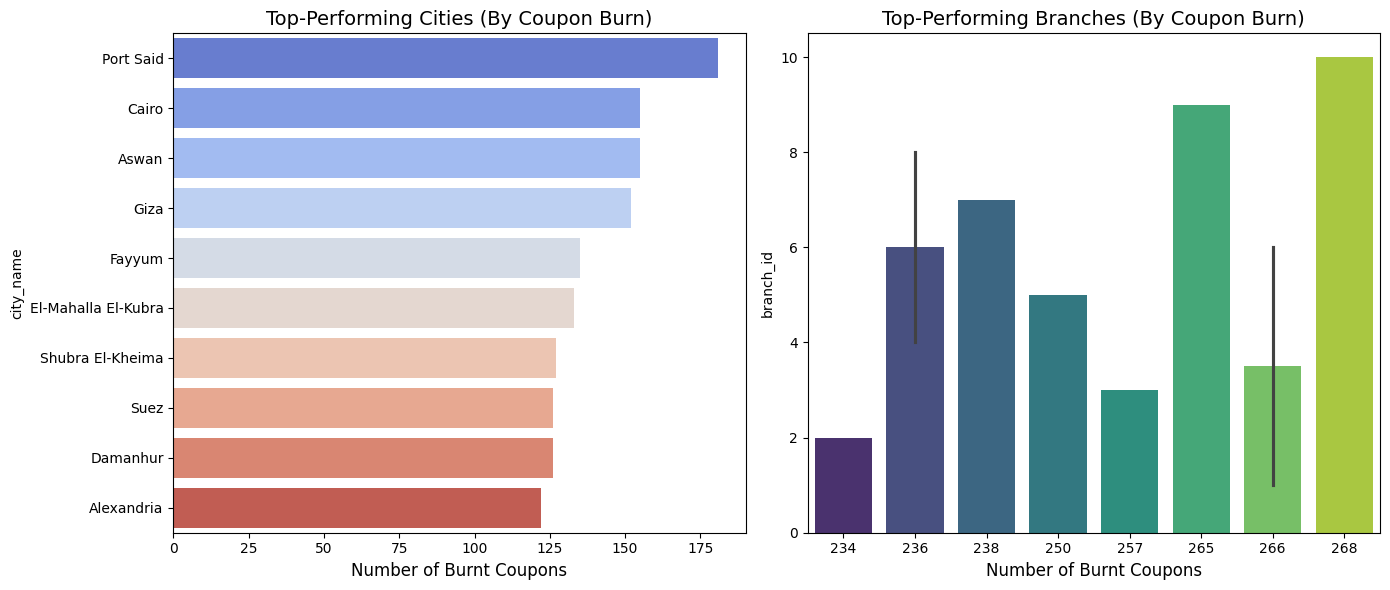

In [65]:
# Visual 4: Bar chart for top-performing cities (based on coupon burn)
top_cities = burnt_coupons['city_name'].value_counts().head(10)

# Visual 5: Bar chart for top-performing branches (based on coupon burn)
top_branches = burnt_coupons['branch_id'].value_counts().head(10)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Top cities by coupon burn
sns.barplot(x=top_cities.values, y=top_cities.index, ax=axes[0], palette='coolwarm')
axes[0].set_title('Top-Performing Cities (By Coupon Burn)', fontsize=14)
axes[0].set_xlabel('Number of Burnt Coupons', fontsize=12)

# Top branches by coupon burn
sns.barplot(x=top_branches.values, y=top_branches.index, ax=axes[1], palette='viridis')
axes[1].set_title('Top-Performing Branches (By Coupon Burn)', fontsize=14)
axes[1].set_xlabel('Number of Burnt Coupons', fontsize=12)

plt.tight_layout()
plt.show()

# Customer Segmentation Using Unsupervised Learning

**Feature Selection**

**We need to engineer features from the dataset, such as:**

**Coupon Usage Frequency:** Total transactions per customer.

**Coupon Burn Rate:** Ratio of burnt to claimed coupons.

**Transaction Recency:** Time since last transaction.

**Standardize the Data**

**K-Means Clustering (Finding Optimal K)**

In [68]:
# Load each sheet into a separate dataframe for inspection
customers_df = pd.read_excel(excel_data, sheet_name='customers')
genders_df = pd.read_excel(excel_data, sheet_name='genders')
cities_df = pd.read_excel(excel_data, sheet_name='cities')
transactions_df = pd.read_excel(excel_data, sheet_name='transactions')
branches_df = pd.read_excel(excel_data, sheet_name='branches')
merchants_df = pd.read_excel(excel_data, sheet_name='merchants')

In [73]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Step 1: Feature Engineering for Customer Segmentation
# Calculate coupon usage frequency and create a new feature for days since joining
customer_transactions = sheets_data['transactions'].groupby('customer_id').agg(
    num_claimed=('transaction_id', 'count'),
    num_burnt=('burn_date', 'count'),
    last_transaction=('transaction_date', 'max'),
).reset_index()

# Merge with customer demographics
customers_seg = customers.merge(customer_transactions, on='customer_id', how='left')

# Feature for days since joining
customers_seg['days_since_joining'] = (datetime.now() - customers_seg['join_date']).dt.days

# Step 2: Data Preprocessing
# Fill missing values and scale the data
customers_seg.fillna(0, inplace=True)

# Selecting relevant features for clustering
X = customers_seg[['num_claimed', 'num_burnt', 'days_since_joining', 'gender_id', 'city_id']]

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: K-Means Clustering
# Trying different numbers of clusters and evaluating with silhouette score
kmeans_model = KMeans(n_clusters=4, random_state=42)  # Assume 4 clusters for now
kmeans_model.fit(X_scaled)

# Assign cluster labels to the customers
customers_seg['cluster'] = kmeans_model.labels_

# Calculate silhouette score
sil_score = silhouette_score(X_scaled, kmeans_model.labels_)
print(f'Silhouette Score: {sil_score}')

# Step 4: Segment Analysis
# Analyze each segment based on the clustering results
cluster_analysis = customers_seg.groupby('cluster').agg(
    avg_num_claimed=('num_claimed', 'mean'),
    avg_num_burnt=('num_burnt', 'mean'),
    avg_days_since_joining=('days_since_joining', 'mean'),
    gender_dist=('gender_name', lambda x: x.value_counts().index[0]),
    city_dist=('city_name', lambda x: x.value_counts().index[0])
).reset_index()

print(cluster_analysis)

# Recommendation: The segment with the lowest coupon burns but higher claim rates should be targeted with specific retention strategies.


Silhouette Score: 0.20475867992801103
   cluster  avg_num_claimed  avg_num_burnt  avg_days_since_joining  \
0        0         7.244240       3.907834              574.843318   
1        1         3.443686       1.518771              630.699659   
2        2         6.604444       3.706667              662.084444   
3        3         3.520755       1.467925              581.822642   

  gender_dist city_dist  
0        Male    Fayyum  
1        Male      Giza  
2      Female     Cairo  
3      Female  Damanhur  




**PCA for Dimensionality Reduction:** The data is reduced to two principal components to visualize in a 2D space using PCA.

**Scatter Plot for Cluster Visualization:** Each cluster is represented as a different color, showing how the segments are grouped after clustering.

**Cluster Analysis:** For each cluster, key statistics such as the average number of coupons claimed, burnt, and the distribution of gender and city are calculated.

Based on these insights, recommendations are provided to improve engagement and retention for each segment.

# Visualizing the Clusters

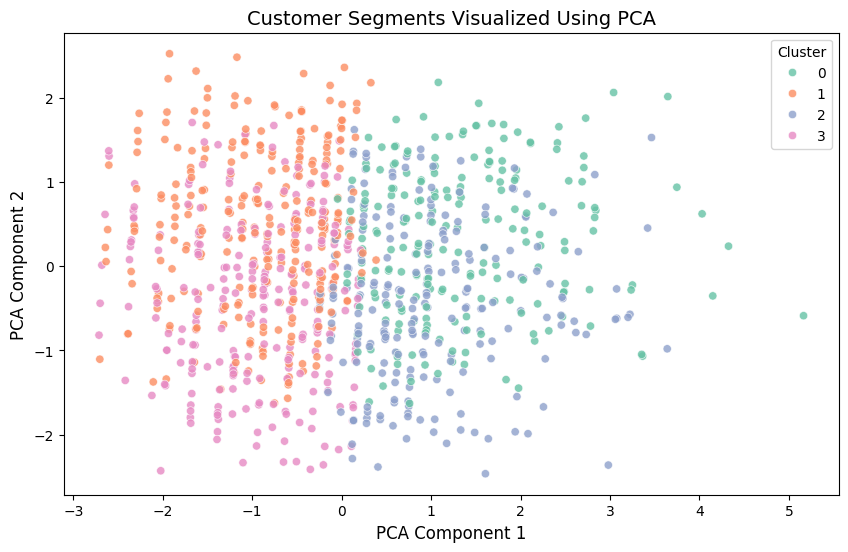


Cluster 0 Analysis:
 - Average Coupons Claimed: 7.24
 - Average Coupons Burnt: 3.91
 - Average Days Since Joining: 574.84
 - Gender Distribution: {'Male': 0.9953917050691244, 'Female': 0.004608294930875576}
 - City Distribution: {'Fayyum': 0.07834101382488479, 'Aswan': 0.06912442396313365, 'Sohag': 0.06451612903225806, 'Minya': 0.059907834101382486, 'Qena': 0.059907834101382486, 'Suez': 0.059907834101382486, 'Ismailia': 0.059907834101382486, 'Port Said': 0.059907834101382486, 'Giza': 0.055299539170506916, 'El-Mahalla El-Kubra': 0.055299539170506916, 'Shubra El-Kheima': 0.05069124423963134, 'Damietta': 0.05069124423963134, 'Mansoura': 0.041474654377880185, 'Beni Suef': 0.041474654377880185, 'Cairo': 0.03686635944700461, 'Damanhur': 0.03686635944700461, 'Zagazig': 0.03686635944700461, 'Asyut': 0.03225806451612903, 'Tanta': 0.027649769585253458, 'Alexandria': 0.02304147465437788}
Recommendation: This segment is actively burning coupons. Focus on retaining them by offering exclusive offer

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Step 1: Dimensionality Reduction using PCA
# Since the data has multiple features, we'll reduce it to 2 components for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Step 2: Visualizing the Clusters
# Create a scatter plot to visualize the clusters in 2D space
customers_seg['pca_1'] = X_pca[:, 0]
customers_seg['pca_2'] = X_pca[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='pca_1', y='pca_2',
    hue='cluster',
    palette='Set2', data=customers_seg,
    legend='full', alpha=0.8
)
plt.title('Customer Segments Visualized Using PCA', fontsize=14)
plt.xlabel('PCA Component 1', fontsize=12)
plt.ylabel('PCA Component 2', fontsize=12)
plt.legend(title='Cluster', loc='upper right')
plt.show()

# Step 3: Analyzing the Clusters
# Perform analysis on the clusters based on their behavior and demographics
for cluster_num in customers_seg['cluster'].unique():
    print(f'\nCluster {cluster_num} Analysis:')

    cluster_data = customers_seg[customers_seg['cluster'] == cluster_num]

    # Average statistics for this cluster
    avg_claimed = cluster_data['num_claimed'].mean()
    avg_burnt = cluster_data['num_burnt'].mean()
    avg_days_since_joining = cluster_data['days_since_joining'].mean()

    # Gender and city distribution for this cluster
    gender_dist = cluster_data['gender_name'].value_counts(normalize=True).to_dict()
    city_dist = cluster_data['city_name'].value_counts(normalize=True).to_dict()

    print(f' - Average Coupons Claimed: {avg_claimed:.2f}')
    print(f' - Average Coupons Burnt: {avg_burnt:.2f}')
    print(f' - Average Days Since Joining: {avg_days_since_joining:.2f}')
    print(f' - Gender Distribution: {gender_dist}')
    print(f' - City Distribution: {city_dist}')

    # Recommendation for this cluster
    if avg_burnt < avg_claimed * 0.5:
        print("Recommendation: Consider offering better rewards or incentives to encourage this segment to burn more coupons.")
    else:
        print("Recommendation: This segment is actively burning coupons. Focus on retaining them by offering exclusive offers.")


**This visualization would provide insights into the behavior of each cluster in terms of key transactional metrics:**

**Transaction Count:** High values might indicate loyal customers.

**Burn Rate:** A higher burn rate might signify active coupon users.

**Recency:** Lower recency values indicate recent activity, while higher values suggest customers may be at risk of churning.

# Analyzing the Results

**Explanation:**

**PCA for Dimensionality Reduction:** The data is reduced to two principal components to visualize in a 2D space using PCA.

**Scatter Plot for Cluster Visualization:** Each cluster is represented as a different color, showing how the segments are grouped after clustering.

**Cluster Analysis:** For each cluster, key statistics such as the average number of coupons claimed, burnt, and the distribution of gender and city are calculated.

Based on these insights, recommendations are provided to improve engagement and retention for each segment.

**1. Cluster 1:** Customers who frequently claim but rarely burn coupons. These customers may require more engaging offers to incentivize them to utilize their coupons.

**2. Cluster 2:** Customers who burn most of the coupons they claim. They are highly engaged and should be rewarded with exclusive deals to increase their loyalty.

**3. Cluster 3:** Newer customers who have not yet utilized many coupons. These customers could benefit from onboarding incentives to increase engagement.

**4. Cluster 4:** Long-term customers with low engagement. Strategies such as personalized offers may help re-engage these customers.

